# Introduction

This project analyzes data about Polish counties called "powiats," which are the second level of Polish administrative division, between the voivodeship (provinces) and the gmina (municipalities or communes). There are two types of powiats: "land counties" (powiaty ziemskie) and "city counties" (miasta na prawach powiatu or powiaty grodzkie), but our main focus will be on the former.

The goal of this project is to explore and analyze various data about powiats and then create machine learning models for predicting powiat revenue.

**Data Source**

All of the data was downloaded from bdl.stat.gov.pl, a database created by Poland's chief government agency, "Statistics Poland." This agency collects and publishes statistics related to the economy, population, and society in Poland at both national and local levels.

## Scoping

### Project Goals

The goal of this project is to showcase and apply the coding skills I acquired through various courses and to use machine learning techniques on a dataset. The primary research question to be answered is whether powiat revenue can be predicted using other data, such as population size or the value of grants received.

### Data

All of the features were downloaded separately from the public Polish database, bdl.stat.gov.pl, which contains data at local levels. All of the data is from 2023.

### Analysis

In this project, I used various statistical and machine learning methods to prepare the data and create ML models. The models were then evaluated to compare their effectiveness and ability to forecast accurately.

### Evaluation

The project will conclude with a summary of the model evaluations. The models were tested using the coefficient of determination and the error in predicting the revenue of Szczecin, which is a city county.


## Import Python Modules

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import GridSearchCV

## Loading the Data
Firstly, I loaded the revenue of powiats, which will serve as the y-values. In Poland, we use commas as decimal separators, so the CSV file uses semicolons as delimiters.

In [2]:
df=pd.read_csv('FINA_1514_CTAB_20240818094145.csv', delimiter=';')
df

,Kod,Nazwa,ogółem;2023;[zł],Unnamed: 3
0,201000,Powiat bolesławiecki,"142399515,72",NaN
1,202000,Powiat dzierżoniowski,"145439131,79",NaN
2,203000,Powiat głogowski,"180534911,75",NaN
3,204000,Powiat górowski,"66650624,91",NaN
4,205000,Powiat jaworski,"107240697,73",NaN
...,...,...,...,...
309,3214000,Powiat stargardzki,"181836873,80",NaN
310,3215000,Powiat szczecinecki,"188819283,31",NaN
311,3216000,Powiat świdwiński,"101987564,35",NaN
312,3217000,Powiat wałecki,"83439875,36",NaN


## Processing the DataFrame
From examining the data types, we can see that our target column 'ogółem;2023;[zł]' needs to be restructured.

In [3]:
df.dtypes

Kod                   int64
Nazwa                object
ogółem;2023;[zł]     object
Unnamed: 3          float64
dtype: object

#### Adjusting columns
Firstly, we should rename the column containing the revenue of powiats, and then we can delete any unnecessary columns. Now, our DataFrame with y-values looks much cleaner.

In [4]:
df.rename(columns={'ogółem;2023;[zł]': 'revenue'}, inplace=True)
df.drop(columns=['Kod', 'Nazwa', 'Unnamed: 3'], inplace=True)
df

,revenue
0,"142399515,72"
1,"145439131,79"
2,"180534911,75"
3,"66650624,91"
4,"107240697,73"
...,...
309,"181836873,80"
310,"188819283,31"
311,"101987564,35"
312,"83439875,36"


#### Changing the data type
For Python to recognize our data as numbers, we need to replace commas with periods. After that, we can change the data type to float, which represents floating-point numbers.

In [5]:
df.revenue=df.revenue.apply(lambda x: x.replace(',', '.'))
df.revenue= df.revenue.astype('float64')
df.dtypes

revenue    float64
dtype: object

#### Checking for null values
It is important to check for any null values in the DataFrame because they could cause problems later. After using the .info() method, we can see that all of the rows have values.

In [6]:
y=df
y.revenue.info() 

<class 'pandas.core.series.Series'>
RangeIndex: 314 entries, 0 to 313
Series name: revenue
Non-Null Count  Dtype  
--------------  -----  
314 non-null    float64
dtypes: float64(1)
memory usage: 2.6 KB


## Plotting the histogram
Next, we can check the distribution of the y-values using a histogram. The plot shows powiat revenue in millions of zloty. The data is visibly right-skewed, which means that most powiats have revenue lower than the mean.

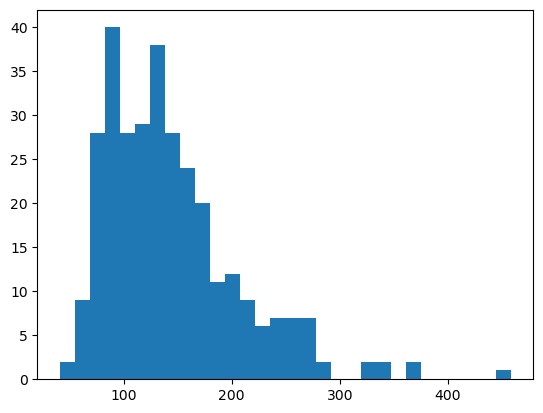

In [7]:
y_in_mil=y.revenue.apply(lambda x: x/1000000) #change to millions
plt.hist(y_in_mil, bins=30)
plt.show()

## Loading the features 
To load all of the data more efficiently, a function was defined. Since all of the features are stored in the same way, we can use the same code to clean and process them.

In [8]:
def feature_creator(file_name, feature_name):
    df=pd.read_csv(file_name, delimiter=';') ## loading dataset
    col_list=list(df.columns) ## Creating column list
    df.rename(columns={col_list[2]: feature_name}, inplace=True) ## Renaming the target column 
    if not df[feature_name].dtype == 'int64': # If the variable is not discrete, Python will interpret it as a string or object
        df[feature_name]=df[feature_name].apply(lambda x: x.replace(',', '.')) # Changing the decimal separator
        df[feature_name]= df[feature_name].astype('float64') # Changing the data type
    df.drop(columns=['Unnamed: 3'], inplace=True) # Deleting unnecessary column
    return df

#### Grants
The first feature is the grants received by the powiat from the government, measured in Polish zloty.

In [9]:
x1=feature_creator('FINA_1517_CTAB_20240818102741.csv', 'grants')
x1

,Kod,Nazwa,grants
0,201000,Powiat bolesławiecki,33579001.90
1,202000,Powiat dzierżoniowski,24447058.48
2,203000,Powiat głogowski,31397165.23
3,204000,Powiat górowski,17451487.64
4,205000,Powiat jaworski,24436025.22
...,...,...,...
309,3214000,Powiat stargardzki,22635742.27
310,3215000,Powiat szczecinecki,44460775.53
311,3216000,Powiat świdwiński,18253073.37
312,3217000,Powiat wałecki,14938476.77


#### Dwelling stock 
The second feature is the number of dwellings in the powiat.

In [10]:
x2=feature_creator('GOSP_2166_CTAB_20240818103417.csv','dwelling_stock')
x2

,Kod,Nazwa,dwelling_stock
0,201000,Powiat bolesławiecki,35291
1,202000,Powiat dzierżoniowski,41221
2,203000,Powiat głogowski,34795
3,204000,Powiat górowski,12329
4,205000,Powiat jaworski,18726
...,...,...,...
309,3214000,Powiat stargardzki,46872
310,3215000,Powiat szczecinecki,30038
311,3216000,Powiat świdwiński,16957
312,3217000,Powiat wałecki,19936


#### Libraries 
This feature represents the number of libraries in the powiat.

In [11]:
x3=feature_creator('KULT_1688_CTAB_20240818125917.csv' ,'libraries')
x3

,Kod,Nazwa,libraries
0,201000,Powiat bolesławiecki,25
1,202000,Powiat dzierżoniowski,21
2,203000,Powiat głogowski,16
3,204000,Powiat górowski,11
4,205000,Powiat jaworski,16
...,...,...,...
309,3214000,Powiat stargardzki,25
310,3215000,Powiat szczecinecki,21
311,3216000,Powiat świdwiński,12
312,3217000,Powiat wałecki,9


#### Cinemas
This feature represents the number of cinemas in the powiat.

In [12]:
x4=feature_creator('KULT_1687_CTAB_20240818130057.csv', 'cinemas')
x4

,Kod,Nazwa,cinemas
0,201000,Powiat bolesławiecki,1
1,202000,Powiat dzierżoniowski,2
2,203000,Powiat głogowski,1
3,204000,Powiat górowski,2
4,205000,Powiat jaworski,1
...,...,...,...
224,3214000,Powiat stargardzki,2
225,3215000,Powiat szczecinecki,1
226,3216000,Powiat świdwiński,1
227,3217000,Powiat wałecki,1


#### Mass events
This feature describes the number of mass events held in the powiat in a given year.

In [13]:
x5=feature_creator('KULT_3400_CTAB_20240818130253.csv', 'mass_events')
x5

,Kod,Nazwa,mass_events
0,201000,Powiat bolesławiecki,4
1,202000,Powiat dzierżoniowski,6
2,203000,Powiat głogowski,2
3,204000,Powiat górowski,2
4,205000,Powiat jaworski,6
...,...,...,...
289,3214000,Powiat stargardzki,2
290,3215000,Powiat szczecinecki,3
291,3216000,Powiat świdwiński,3
292,3217000,Powiat wałecki,5


#### Forest land
The next feature describes the land in the powiat covered by forests, measured in hectares.

In [14]:
x6=feature_creator('LEŚN_1487_CTAB_20240818130423.csv', 'forest_land')
x6

,Kod,Nazwa,forest_land
0,201000,Powiat bolesławiecki,935.08
1,202000,Powiat dzierżoniowski,280.23
2,203000,Powiat głogowski,718.50
3,204000,Powiat górowski,1013.41
4,205000,Powiat jaworski,701.25
...,...,...,...
309,3214000,Powiat stargardzki,2456.17
310,3215000,Powiat szczecinecki,2841.45
311,3216000,Powiat świdwiński,1969.96
312,3217000,Powiat wałecki,1209.87


#### Population
This feature represents the number of people living in the powiat.

In [15]:
x7=feature_creator('LUDN_2137_CTAB_20240818130533.csv', 'population')
x7

,Kod,Nazwa,population
0,201000,Powiat bolesławiecki,87642
1,202000,Powiat dzierżoniowski,94740
2,203000,Powiat głogowski,85043
3,204000,Powiat górowski,32459
4,205000,Powiat jaworski,47213
...,...,...,...
309,3214000,Powiat stargardzki,119090
310,3215000,Powiat szczecinecki,72717
311,3216000,Powiat świdwiński,43237
312,3217000,Powiat wałecki,50003


#### Pharmacies
This feature counts the number of pharmacies in the powiat.

In [16]:
x8=feature_creator('OCHR_2873_CTAB_20240818130633.csv', 'pharmacies')
x8

,Kod,Nazwa,pharmacies
0,201000,Powiat bolesławiecki,25
1,202000,Powiat dzierżoniowski,33
2,203000,Powiat głogowski,26
3,204000,Powiat górowski,7
4,205000,Powiat jaworski,14
...,...,...,...
309,3214000,Powiat stargardzki,34
310,3215000,Powiat szczecinecki,23
311,3216000,Powiat świdwiński,11
312,3217000,Powiat wałecki,16


#### Enterprises
This feature describes the number of enterprises in the powiat.

In [17]:
x9=feature_creator('PODM_2315_CTAB_20240818130747.csv', 'enterprises')
x9

,Kod,Nazwa,enterprises
0,201000,Powiat bolesławiecki,10482
1,202000,Powiat dzierżoniowski,12091
2,203000,Powiat głogowski,8856
3,204000,Powiat górowski,3553
4,205000,Powiat jaworski,5686
...,...,...,...
309,3214000,Powiat stargardzki,14201
310,3215000,Powiat szczecinecki,8717
311,3216000,Powiat świdwiński,5115
312,3217000,Powiat wałecki,6003


#### Area
The next feature measures the area of the powiat in square kilometers.

In [18]:
x10=feature_creator('PODZ_1410_CTAB_20240818130855.csv', 'area')
x10

,Kod,Nazwa,area
0,201000,Powiat bolesławiecki,1303
1,202000,Powiat dzierżoniowski,479
2,203000,Powiat głogowski,443
3,204000,Powiat górowski,738
4,205000,Powiat jaworski,581
...,...,...,...
309,3214000,Powiat stargardzki,1520
310,3215000,Powiat szczecinecki,1766
311,3216000,Powiat świdwiński,1093
312,3217000,Powiat wałecki,1415


#### Registered unemployed persons
This feature counts the number of persons registered as unemployed.

In [19]:
x11=feature_creator('RYNE_1364_CTAB_20240818131308.csv', 'reg_unemployed_pers')
x11

,Kod,Nazwa,reg_unemployed_pers
0,201000,Powiat bolesławiecki,886
1,202000,Powiat dzierżoniowski,1593
2,203000,Powiat głogowski,1761
3,204000,Powiat górowski,1302
4,205000,Powiat jaworski,1550
...,...,...,...
309,3214000,Powiat stargardzki,2685
310,3215000,Powiat szczecinecki,3322
311,3216000,Powiat świdwiński,1647
312,3217000,Powiat wałecki,1335


## Area owned
The last feature describes the area directly owned by the powiat, measured in square kilometers.

In [20]:
x12=feature_creator('SAMO_3875_CTAB_20240818131525.csv', 'area_owned')
x12

,Kod,Nazwa,area_owned
0,201000,Powiat bolesławiecki,388
1,202000,Powiat dzierżoniowski,321
2,203000,Powiat głogowski,239
3,204000,Powiat górowski,303
4,205000,Powiat jaworski,351
...,...,...,...
302,3214000,Powiat stargardzki,583
303,3215000,Powiat szczecinecki,945
304,3216000,Powiat świdwiński,633
305,3217000,Powiat wałecki,133


## Merging the features
In order to use the features in any model, we need to merge the DataFrames into one.

In [21]:
dfs=[x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12] # List of the DataFrames to merge

# Using reduce to apply merge to a list of DFs
x_df = reduce(lambda left, right: pd.merge(left, right, on=['Kod','Nazwa'], how='outer'), dfs) 

x_df

,Kod,Nazwa,grants,dwelling_stock,libraries,cinemas,mass_events,forest_land,population,pharmacies,enterprises,area,reg_unemployed_pers,area_owned
0,201000,Powiat bolesławiecki,33579001.90,35291,25,1.0,4.0,935.08,87642,25,10482,1303,886,388.0
1,202000,Powiat dzierżoniowski,24447058.48,41221,21,2.0,6.0,280.23,94740,33,12091,479,1593,321.0
2,203000,Powiat głogowski,31397165.23,34795,16,1.0,2.0,718.50,85043,26,8856,443,1761,239.0
3,204000,Powiat górowski,17451487.64,12329,11,2.0,2.0,1013.41,32459,7,3553,738,1302,303.0
4,205000,Powiat jaworski,24436025.22,18726,16,1.0,6.0,701.25,47213,14,5686,581,1550,351.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309,3214000,Powiat stargardzki,22635742.27,46872,25,2.0,2.0,2456.17,119090,34,14201,1520,2685,583.0
310,3215000,Powiat szczecinecki,44460775.53,30038,21,1.0,3.0,2841.45,72717,23,8717,1766,3322,945.0
311,3216000,Powiat świdwiński,18253073.37,16957,12,1.0,3.0,1969.96,43237,11,5115,1093,1647,633.0
312,3217000,Powiat wałecki,14938476.77,19936,9,1.0,5.0,1209.87,50003,16,6003,1415,1335,133.0


## Exploring the data

In [22]:
x_df.describe()

,Kod,grants,dwelling_stock,libraries,cinemas,mass_events,forest_land,population,pharmacies,enterprises,area,reg_unemployed_pers,area_owned
count,3.140000e+02,3.140000e+02,314.000000,314.000000,229.000000,294.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,307.000000
mean,1.689806e+06,3.433956e+07,29875.958599,20.324841,1.349345,5.183673,5839.356433,80663.429936,22.242038,9135.305732,973.716561,1897.570064,459.328990
std,9.508515e+05,1.462645e+07,17512.724746,10.421296,0.599899,8.163450,6461.632060,47690.776338,13.140869,7258.486048,444.095541,1009.223823,251.741307
min,2.010000e+05,6.567488e+06,7170.000000,6.000000,1.000000,1.000000,34.850000,18645.000000,4.000000,1710.000000,158.000000,328.000000,3.000000
25%,1.002250e+06,2.404693e+07,18378.250000,13.000000,1.000000,2.000000,1218.935000,49244.250000,13.250000,4749.250000,652.750000,1207.000000,302.000000
50%,1.603500e+06,3.302992e+07,25215.500000,18.000000,1.000000,4.000000,3010.650000,69174.000000,19.000000,7427.500000,881.000000,1678.500000,426.000000
75%,2.602750e+06,4.224052e+07,36566.500000,25.000000,2.000000,6.000000,8344.420000,99266.250000,28.000000,10669.750000,1223.000000,2404.500000,583.500000
max,3.218000e+06,1.084385e+08,163811.000000,65.000000,4.000000,125.000000,39014.330000,448663.000000,133.000000,77739.000000,2977.000000,7458.000000,1602.000000


#### Checking for null-values
There are some null values in the dataset that we need to handle.

In [23]:
x_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 314 entries, 0 to 313
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Kod                  314 non-null    int64  
 1   Nazwa                314 non-null    object 
 2   grants               314 non-null    float64
 3   dwelling_stock       314 non-null    int64  
 4   libraries            314 non-null    int64  
 5   cinemas              229 non-null    float64
 6   mass_events          294 non-null    float64
 7   forest_land          314 non-null    float64
 8   population           314 non-null    int64  
 9   pharmacies           314 non-null    int64  
 10  enterprises          314 non-null    int64  
 11  area                 314 non-null    int64  
 12  reg_unemployed_pers  314 non-null    int64  
 13  area_owned           307 non-null    float64
dtypes: float64(5), int64(8), object(1)
memory usage: 34.5+ KB


## Handling null-values
The first feature with null values is cinemas. By examining the counts of all values in that column, we can see that there are no zeros. Therefore, we can assume that the NaN values should be replaced with zeros.

In [24]:
x_df.cinemas.value_counts(dropna=False)

cinemas
1.0    163
NaN     85
2.0     53
3.0     12
4.0      1
Name: count, dtype: int64

In [25]:
x_df.cinemas.fillna(value=0, inplace=True) #replacing the Nan value with 0

In [26]:
x_df.cinemas.value_counts(dropna=False)

cinemas
1.0    163
0.0     85
2.0     53
3.0     12
4.0      1
Name: count, dtype: int64

Similarly, by examining the values in the mass_events column, we can see that none of them are zero. Therefore, we can assume that this issue may occur in any row where zero values are expected.

In [27]:
x_df.mass_events.value_counts(dropna=False)

mass_events
2.0      53
3.0      46
1.0      44
4.0      41
5.0      29
6.0      20
NaN      20
7.0      12
8.0       8
10.0      7
11.0      6
9.0       6
12.0      4
14.0      4
17.0      4
18.0      2
13.0      2
15.0      1
125.0     1
19.0      1
24.0      1
25.0      1
27.0      1
Name: count, dtype: int64

In [28]:
x_df.mass_events.fillna(value=0, inplace=True)

In [29]:
x_df.mass_events.value_counts(dropna=False)

mass_events
2.0      53
3.0      46
1.0      44
4.0      41
5.0      29
6.0      20
0.0      20
7.0      12
8.0       8
10.0      7
11.0      6
9.0       6
12.0      4
14.0      4
17.0      4
18.0      2
13.0      2
15.0      1
125.0     1
19.0      1
24.0      1
25.0      1
27.0      1
Name: count, dtype: int64

In [30]:
x_df.area_owned.min() # Checing for the mimumum value in area_owned column

3.0

In [31]:
x_df.area_owned.fillna(value=0, inplace=True)

## Creating a Clean Feature DataFrame
After handling the NaN values, our data is almost ready to use. The last step is to drop the remaining unnecessary columns.

In [32]:
X=x_df.drop(columns=['Kod', 'Nazwa'])
X

,grants,dwelling_stock,libraries,cinemas,mass_events,forest_land,population,pharmacies,enterprises,area,reg_unemployed_pers,area_owned
0,33579001.90,35291,25,1.0,4.0,935.08,87642,25,10482,1303,886,388.0
1,24447058.48,41221,21,2.0,6.0,280.23,94740,33,12091,479,1593,321.0
2,31397165.23,34795,16,1.0,2.0,718.50,85043,26,8856,443,1761,239.0
3,17451487.64,12329,11,2.0,2.0,1013.41,32459,7,3553,738,1302,303.0
4,24436025.22,18726,16,1.0,6.0,701.25,47213,14,5686,581,1550,351.0
...,...,...,...,...,...,...,...,...,...,...,...,...
309,22635742.27,46872,25,2.0,2.0,2456.17,119090,34,14201,1520,2685,583.0
310,44460775.53,30038,21,1.0,3.0,2841.45,72717,23,8717,1766,3322,945.0
311,18253073.37,16957,12,1.0,3.0,1969.96,43237,11,5115,1093,1647,633.0
312,14938476.77,19936,9,1.0,5.0,1209.87,50003,16,6003,1415,1335,133.0


## Creating the Model with Raw Data
With the data prepared, the training process can begin. We will start with a simple LinearRegression model from the scikit-learn library. This model uses the Ordinary Least Squares method to identify linear relationships. The model will be trained with the raw data, without any additional preprocessing.

In [33]:
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.33, random_state=1) # splitting the data for training and testing
model= LinearRegression()
model.fit(X_train, y_train) # fitting the model

LinearRegression()

#### Model evaluation 
The model was evaluated based on the coefficient of determination, which indicates how well the model fits the data. A value closer to 1 indicates a better fit. The model achieved a coefficient of 0.92 on the training data and 0.89 on the testing data, suggesting that the model fits the data very well.

In [34]:
train_score=model.score(X_train, y_train)
test_score=model.score(X_test, y_test)
print(f'train score: {train_score}\ntest score: {test_score}')

train score: 0.9174088872586378
test score: 0.8937767514155401


#### Using the Model for Predictions

To evaluate the model further, it was used to predict the revenue of Szczecin (a city county). This could be a challenging task for the model due to the differences in scale among the variables, but we will give it a try.

In [35]:
y_szczecin=3260271519.90 
data = {
    'grants': 811748436.65, 
    'dwelling_stock': 194935, 
    'libraries': 34, 
    'cinemas': 5, 
    'mass_events': 52, 
    'forest_land': 2646.44, 
    'population': 389066, 
    'pharmacies': 151, 
    'enterprises': 75453, 
    'area': 301, 
    'reg_unemployed_pers': 5351, 
    'area_owned': 10987
}
x_szczecin = pd.DataFrame(data, index=[0])
x_szczecin

,grants,dwelling_stock,libraries,cinemas,mass_events,forest_land,population,pharmacies,enterprises,area,reg_unemployed_pers,area_owned
0,8.117484e+08,194935,34,5,52,2646.44,389066,151,75453,301,5351,10987


In [36]:
prediction=model.predict(x_szczecin)
prediction= round(float(prediction[0]), 2)
prediction


1648921336.27

The model did not make a great prediction. The revenue predicted for Szczecin is less than half of the actual value.

In [37]:
pred_error=y_szczecin-prediction
pred_error_prec=round((pred_error/y_szczecin)*100, 2)
print(f'prediction error: {pred_error}, {pred_error_prec}%')

prediction error: 1611350183.63, 49.42%


## Feature Selection
Not all features are necessarily beneficial for use in the model. Therefore, it is a common practice to use various methods to choose the best set of features to improve the model's performance.

### Filter Methods
Filter methods are based on statistical analysis. The first thing to check is the coefficient of variance, which tells us how much the values differ between rows in a feature. This coefficient also indicates the level of information a feature provides. The higher the CV, the more information a feature offers. We can consider a low value for the coefficient of variance to be 10%, and since all of our features have a much higher CV than this threshold, we should not reject any of them.

In [38]:
X.apply(lambda x: np.std(x, ddof=1) / np.mean(x) * 100)

grants                  42.593596
dwelling_stock          58.618118
libraries               51.273690
cinemas                 80.191369
mass_events            164.818128
forest_land            110.656579
population              59.123169
pharmacies              59.081228
enterprises             79.455316
area                    45.608297
reg_unemployed_pers     53.185062
area_owned              57.452060
dtype: float64

#### Pearson’s correlation
Pearson’s correlation coefficient is useful for measuring the linear relationship between two numeric variables — a coefficient close to 1 represents a positive correlation, -1 represents a negative correlation, and 0 represents no correlation. There are 2 main ways of using correlation for feature selection — to detect correlation between features and to detect correlation between a feature and the target variable. 

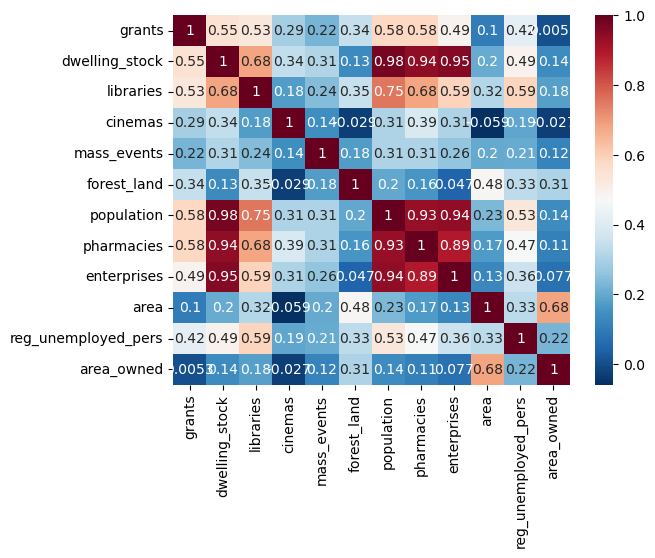

In [39]:
corr_matrix = X.corr() # creating correlation matrix using pandas corr method

sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r')
plt.show()

When two features are highly correlated with one another, then keeping just one to be used in the model will be enough because otherwise they provide duplicate information. The second variable would only be redundant and serve to contribute unnecessary noise.

We are going to take 0.7 as a threshold for high correlation between features. 

In [40]:
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > 0.7: # 0.7 will serve as the threshold for identifying high correlations between features
            print(corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j])

population dwelling_stock 0.9759952346560692
population libraries 0.7519903226487015
pharmacies dwelling_stock 0.9383688901005055
pharmacies population 0.9305216090483661
enterprises dwelling_stock 0.9546166871265501
enterprises population 0.939708233095284
enterprises pharmacies 0.893448377691439


In [41]:
X_y = X.copy()
X_y['revenue'] = y # To calculate the correlation between X and y, we need to combine them into a single DataFrame
X_y

,grants,dwelling_stock,libraries,cinemas,mass_events,forest_land,population,pharmacies,enterprises,area,reg_unemployed_pers,area_owned,revenue
0,33579001.90,35291,25,1.0,4.0,935.08,87642,25,10482,1303,886,388.0,1.423995e+08
1,24447058.48,41221,21,2.0,6.0,280.23,94740,33,12091,479,1593,321.0,1.454391e+08
2,31397165.23,34795,16,1.0,2.0,718.50,85043,26,8856,443,1761,239.0,1.805349e+08
3,17451487.64,12329,11,2.0,2.0,1013.41,32459,7,3553,738,1302,303.0,6.665062e+07
4,24436025.22,18726,16,1.0,6.0,701.25,47213,14,5686,581,1550,351.0,1.072407e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...
309,22635742.27,46872,25,2.0,2.0,2456.17,119090,34,14201,1520,2685,583.0,1.818369e+08
310,44460775.53,30038,21,1.0,3.0,2841.45,72717,23,8717,1766,3322,945.0,1.888193e+08
311,18253073.37,16957,12,1.0,3.0,1969.96,43237,11,5115,1093,1647,633.0,1.019876e+08
312,14938476.77,19936,9,1.0,5.0,1209.87,50003,16,6003,1415,1335,133.0,8.343988e+07


The second way correlation can be used is to determine if there is a relationship between a feature and the target variable. In this case, a stronger correlation is better. If a feature has a low correlation with the target variable, with a coefficient between -0.3 and 0.3, it may not be very predictive and could potentially be filtered out.

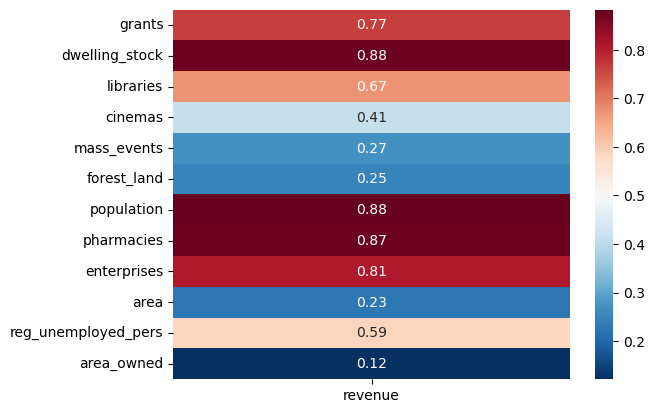

In [42]:
corr_matrix = X_y.corr()

corr_target = corr_matrix[['revenue']].drop(labels=['revenue']) # Only the revenue column is needed

sns.heatmap(corr_target, annot=True, cmap='RdBu_r')
plt.show()

To prevent duplicate information, the following features were filtered out: dwelling stock, libraries, pharmacies, and enterprises. These features were chosen because they had the same or lower correlation with revenue. Additionally, we dropped mass events, forest land, area, and area owned due to their low correlation with the target variable (less than 0.3).

In [43]:
X_filtered= X.drop(columns=['dwelling_stock', 'libraries', 'pharmacies', 'enterprises', 'mass_events', 'forest_land', 'area', 'area_owned'])
X_filtered

,grants,cinemas,population,reg_unemployed_pers
0,33579001.90,1.0,87642,886
1,24447058.48,2.0,94740,1593
2,31397165.23,1.0,85043,1761
3,17451487.64,2.0,32459,1302
4,24436025.22,1.0,47213,1550
...,...,...,...,...
309,22635742.27,2.0,119090,2685
310,44460775.53,1.0,72717,3322
311,18253073.37,1.0,43237,1647
312,14938476.77,1.0,50003,1335


## Distribution
Before fitting a linear regression model, it is important to inspect the distributions of the features. Skewness in the data might introduce bias to the model. From the charts below, we can see that all of our features are right-skewed, which needs to be addressed.

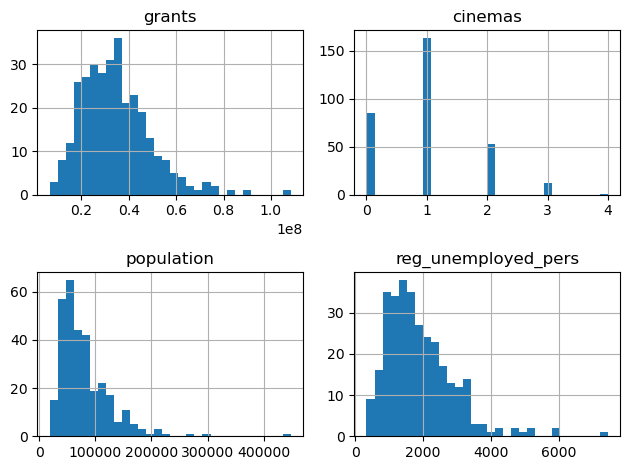

In [44]:
for i, col in enumerate(list(X_filtered.columns)):
    plt.subplot(2, 2, i+1)  
    X_filtered[col].hist(bins=30)
    plt.title(col)
plt.tight_layout()
plt.show()

### Standardization
Standardization is a type of normalization technique. It centers our data and then divides it by the standard deviation. After standardization, the entire dataset will have a mean of zero and a standard deviation of one. To implement this, we will use StandardScaler() from scikit-learn.

In [45]:
scaler = StandardScaler()
X_fil_scaled= scaler.fit_transform(X_filtered)

In [46]:
X_fil_scaled=pd.DataFrame(X_fil_scaled, columns=list(X_filtered.columns))
X_fil_scaled

,grants,cinemas,population,reg_unemployed_pers
0,-0.052082,0.020210,0.146563,-1.003925
1,-0.677423,1.289428,0.295634,-0.302268
2,-0.201491,0.020210,0.091979,-0.135538
3,-1.156468,1.289428,-1.012384,-0.591069
4,-0.678178,0.020210,-0.702522,-0.344943
...,...,...,...,...
309,-0.801459,1.289428,0.807030,0.781479
310,0.693085,0.020210,-0.166890,1.413664
311,-1.101577,0.020210,-0.786026,-0.248676
312,-1.328555,0.020210,-0.643927,-0.558318


As you can see from the plots, standardization could not handle the skewness in our data, and the features are still not centered. Therefore, we need to use other techniques.

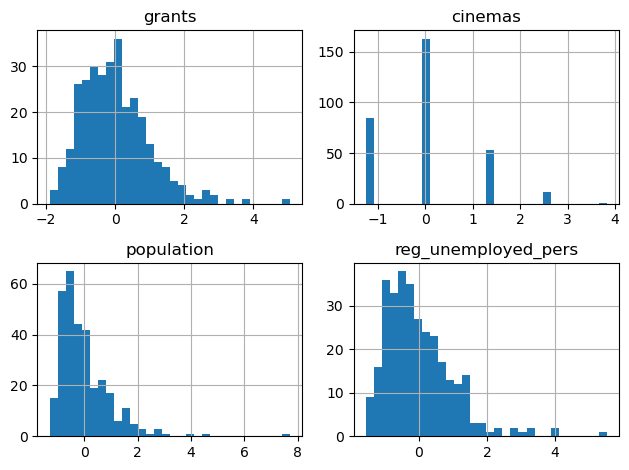

In [47]:
for i, col in enumerate(list(X_fil_scaled.columns)):
    plt.subplot(2, 2, i+1)  
    X_fil_scaled[col].hist(bins=30)
    plt.title(col)
plt.tight_layout()
plt.show()

### Natural log transformation
To handle extreme right skewness, we can use a natural log transformation. This transformation will make the data distribution closer to a “normal” distribution. It also changes the scale, significantly reducing the range of the values. One drawback of this method is that it cannot handle values less than or equal to zero, as the natural logarithm of a non-positive number is undefined. Therefore, we need to drop all rows with zero values.

In [48]:
X_filtered_for_log = X_filtered[(X_filtered != 0).all(axis=1)] # dropping all of the rows with 0 values in any column
X_fil_log=pd.DataFrame()
for i in list(X_filtered.columns):
    
    X_fil_log[i]=np.log(X_filtered_for_log[i]) # performing log transformation
X_fil_log

,grants,cinemas,population,reg_unemployed_pers
0,17.329411,0.000000,11.381016,6.786717
1,17.012020,0.693147,11.458892,7.373374
2,17.262228,0.000000,11.350912,7.473637
3,16.674935,0.693147,10.387733,7.171657
4,17.011569,0.000000,10.762425,7.346010
...,...,...,...,...
309,16.935041,0.693147,11.687635,7.895436
310,17.610118,0.000000,11.194330,8.108322
311,16.719844,0.000000,10.674452,7.406711
312,16.519451,0.000000,10.819838,7.196687


As shown in the plots, all of the features except for cinemas are now normally distributed.

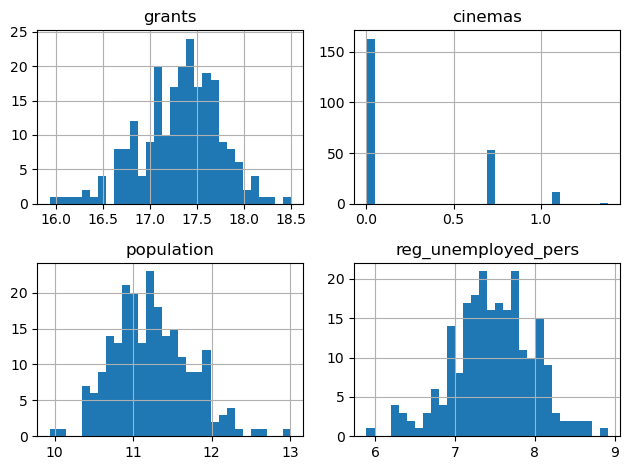

In [49]:
for i, col in enumerate(list(X_fil_log.columns)):
    plt.subplot(2, 2, i+1)  
    X_fil_log[col].hist(bins=30)
    plt.title(col)
plt.tight_layout()
plt.show()

After the log transformation, it is still best to standardize the data.

In [50]:
scaler_for_log = StandardScaler()
scaler_for_log.fit(X_fil_log)
X_fil_log_sc= scaler_for_log.transform(X_fil_log)
X_fil_log_sc=pd.DataFrame(X_fil_log_sc, columns=X_fil_log.columns)

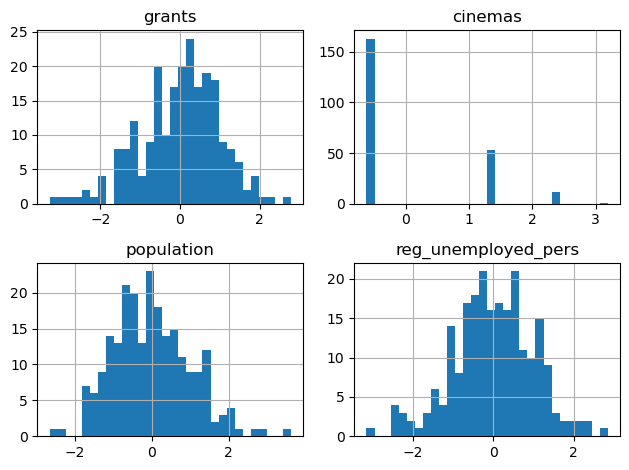

In [51]:
for i, col in enumerate(list(X_fil_log_sc.columns)):
    plt.subplot(2, 2, i+1)  
    X_fil_log_sc[col].hist(bins=30)
    plt.title(col)
plt.tight_layout()
plt.show()

## Training the Model on Processed Data
With the data processed, we can train the model. Although it did not perform as well as the previous model, it did better on the test set than on the training set, which might suggest that the model is more flexible.

In [52]:
new_y=y.loc[list(X_fil_log.index)] # the y variable needs to be modified to match the number of rows in the X DataFrame
X_train, X_test, y_train, y_test= train_test_split(X_fil_log_sc, new_y, test_size=0.33, random_state=1)
model_2= LinearRegression()
model_2.fit(X_train, y_train)
train_score=model_2.score(X_train, y_train)
test_score=model_2.score(X_test, y_test)
print(f'train score: {train_score}\ntest score: {test_score}')

train score: 0.8523863467636325
test score: 0.8724638442623105


### Using the Model for Predictions
To make a prediction for Szczecin, we need to drop unnecessary columns and perform the same log transformation on the remaining ones.

In [53]:
x_szczecin_fil=x_szczecin.drop(columns=['dwelling_stock', 'libraries', 'pharmacies', 'enterprises', 'mass_events', 'forest_land', 'area', 'area_owned'])
x_szczecin_log=pd.DataFrame()
for i in list(x_szczecin_fil.columns):
    x_szczecin_log[i]=np.log(x_szczecin_fil[i])
x_szczecin_log_sc=scaler_for_log.transform(x_szczecin_log)
x_szczecin_log_sc= pd.DataFrame(x_szczecin_log_sc, columns=x_szczecin_fil.columns)
prediction=model_2.predict(x_szczecin_log_sc)
prediction= round(float(prediction[0]), 2)
prediction

485263829.89

The second model performed poorly in predicting the revenue for Szczecin, with an error of more than 85%.

In [54]:
pred_error=abs(y_szczecin-prediction)
pred_error_prec=round((pred_error/y_szczecin)*100, 2)
print(f'prediction error: {pred_error}, {pred_error_prec}%')

prediction error: 2775007690.01, 85.12%


## Wrapper Methods
Wrapper methods are another way of selecting features for machine learning models. A wrapper method is an algorithm that selects features by evaluating the performance of a machine learning model on different subsets of features. These algorithms add or remove features one at a time based on how useful those features are to the model.

### Using Recursive Feature Elimination
The Recursive Feature Elimination (RFE) algorithm starts by training a model with all available features. It then ranks each feature according to an importance metric and removes the least important one. The algorithm then trains the model on the smaller feature set, ranks those features, and removes the least important one again. The process stops when the desired number of features is reached. In Python, we can implement this using the sklearn library. After selecting two features, the model fit the data very well, scoring 0.88. The two features selected were grants and dwelling stock.

In [55]:
scaler = StandardScaler()
scaler.fit(X)
X_scaled= scaler.transform(X) # before using RFE data needs to be scaled
lr=LinearRegression()
model_3=RFE(lr, n_features_to_select=2)
model_3.fit(X_scaled, y)
score=model_3.score(X_scaled, y)
print(f'score: {score}')
model_features = [f for (f, support) in zip(list(X.columns), model_3.support_) if support] # printing the features that was picked by the model

print(model_features)

score: 0.8815831451756247
['grants', 'dwelling_stock']


In [56]:
x_szczecin_scaled= scaler.transform(x_szczecin)
prediction=model_3.predict(x_szczecin_scaled)
prediction= round(float(prediction[0]), 2)
prediction

1872328576.88

### Using the model for prediction
Using only two features, the model did a decent job predicting Szczecin's revenue, with a 43% error—the lowest error we've achieved so far.

In [57]:
pred_error=y_szczecin-prediction
pred_error_prec=round((pred_error/y_szczecin)*100, 2)
print(f'prediction error: {pred_error}, {pred_error_prec}%')

prediction error: 1387942943.02, 42.57%


## Gradient Descent and Grid Search
The final model we will train uses gradient descent to find a linear relationship between predictor variables and the outcome variable. Gradient descent is an iterative process that uses calculus to get closer to the exact coefficients one step at a time, based on a loss function.

Grid search involves testing a model on a list of hyperparameter values determined beforehand. We will tune the alpha, penalty, and learning rate hyperparameters.

#### Alpha
The SGDRegressor from sklearn that we are using is quite sophisticated. It employs regularization, which, in simple terms, penalizes models for overfitting by adding a “penalty term” to the loss function. Overfitting occurs when the model relies too much on the training data, performing well on it but poorly on other data. The alpha parameter allows us to control the level of regularization in our model. An alpha of zero is equivalent to no regularization, while increasing alpha strengthens regularization. This makes the model less prone to overfitting but may also reduce its efficiency.

#### Penalty
The two most commonly used methods of regularization are Lasso (or L1) and Ridge (or L2) regularization. The ElasticNet method combines both L1 and L2 regularization.

#### Learning Rate
The learning rate parameter controls how much the model weights are updated with each step during training. A higher learning rate might speed up convergence but risks overshooting the optimal solution, while a lower learning rate can lead to more precise convergence but may require more iterations to reach the optimal solution. The learning rate can take four values:
Constant: The learning rate remains fixed throughout training.
Adaptive: The learning rate adjusts based on the training progress.
Invscaling: The learning rate decreases as the number of iterations increases, following an inverse scaling rule.
Optimal: Uses a heuristic to automatically determine a learning rate that is theoretically optimal for the current problem.

In [58]:
X_train, X_test, y_train, y_test= train_test_split(X_scaled, np.ravel(y), test_size=0.33, random_state=1)
alpha=np.logspace(-6, 0, 100) # an array of values between 0.000001 and 1.0
param_grid = {
    'alpha': alpha,
    'penalty': ['l2', 'l1', 'elasticnet'],
    'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive']
}
model_4 = GridSearchCV(estimator = SGDRegressor(), param_grid = param_grid, cv = 5, n_jobs=-1)
model_4.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SGDRegressor(), n_jobs=-1,
             param_grid={'alpha': array([1.00000000e-06, 1.14975700e-06, 1.32194115e-06, 1.51991108e-06,
       1.74752840e-06, 2.00923300e-06, 2.31012970e-06, 2.65608778e-06,
       3.05385551e-06, 3.51119173e-06, 4.03701726e-06, 4.64158883e-06,
       5.33669923e-06, 6.13590727e-06, 7.05480231e-06, 8.11130831e-06,
       9.32603347e-06, 1.07226722e-05,...
       7.05480231e-02, 8.11130831e-02, 9.32603347e-02, 1.07226722e-01,
       1.23284674e-01, 1.41747416e-01, 1.62975083e-01, 1.87381742e-01,
       2.15443469e-01, 2.47707636e-01, 2.84803587e-01, 3.27454916e-01,
       3.76493581e-01, 4.32876128e-01, 4.97702356e-01, 5.72236766e-01,
       6.57933225e-01, 7.56463328e-01, 8.69749003e-01, 1.00000000e+00]),
                         'learning_rate': ['constant', 'optimal', 'invscaling',
                                           'adaptive'],
                         'penalty': ['l2', 'l1', 'elasticnet']})

### Model evaluation 
The Grid Search algorithm selected the following hyperparameters: alpha = 0.00002, learning rate = invscaling, and penalty = elasticnet. With these parameters, the model performed very well on both the training and test data.

In [59]:
print(f'best parameters: {model_4.best_params_}')
train_score=model_4.score(X_train, y_train)
test_score=model_4.score(X_test, y_test)
print(f'train score: {train_score}\ntest score: {test_score}')

best parameters: {'alpha': 0.00023101297000831605, 'learning_rate': 'constant', 'penalty': 'l2'}
train score: 0.9016273893697584
test score: 0.8832365843809036


In [60]:
prediction=model_4.predict(x_szczecin_scaled)
prediction= round(float(prediction[0]), 2)
prediction

1593265511.83

### Using the model for prediction
The prediction made by this model is very similar to the one produced by the first model. Therefore, like the previous model, it does not provide a good prediction.

In [61]:
pred_error=(y_szczecin-prediction)
pred_error_prec=round((pred_error/y_szczecin)*100, 2)
print(f'prediction error: {pred_error}, {pred_error_prec}%')

prediction error: 1667006008.0700002, 51.13%


## Evaluation
All of our models performed well on the training and testing data, with the best results coming from the first model trained on raw data and the last model using gradient descent. However, all models struggled with predicting the revenue for Szczecin. The best prediction was made by the third model, which used Recursive Feature Elimination to filter features, achieving an error of 42.57%.